In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
x = np.linspace(0, 50, 501)

In [3]:
y = np.sin(x)

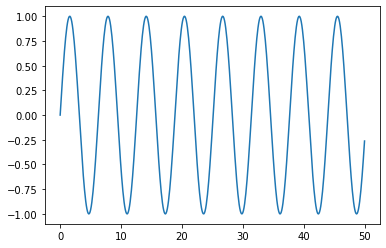

In [4]:
plt.plot(x, y)

In [5]:
df = pd.DataFrame(y, index = x, columns=['Sine'])
df.head()

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


In [6]:
len(df)

501

In [7]:
test_percent = 0.2

In [8]:
501 * (20/100)

100.2

In [9]:
train_df = df.iloc[:400]
test_df = df.iloc[400:]

In [10]:
train_df.head()

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


In [11]:
test_df.head()

,Sine
40.0,0.745113
40.1,0.674808
40.2,0.597760
40.3,0.514740
40.4,0.426577


In [12]:
from sklearn.preprocessing import MinMaxScaler

In [13]:
scaler = MinMaxScaler()

In [14]:
scaler.fit(train_df)

MinMaxScaler()

In [15]:
train = scaler.transform(train_df)
test = scaler.transform(test_df)

In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
generator = TimeseriesGenerator(train, train, length = 2, batch_size = 1)

In [18]:
generator[0]

(array([[[0.49999912],
         [0.54991622]]]),
 array([[0.59933458]]))

In [19]:
generator[1]

(array([[[0.54991622],
         [0.59933458]]]),
 array([[0.64776041]]))

In [20]:
generator = TimeseriesGenerator(train, train, length = 50, batch_size = 1)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [22]:
length = 50
n_features = 1

In [23]:
model = Sequential()

model.add(SimpleRNN(50, input_shape=(50, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

2022-05-04 16:26:02.285746: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 50)                2600      
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(generator, epochs = 5)

Epoch 1/5
350/350 [==============================] - 6s 10ms/step - loss: 0.0016
Epoch 2/5
350/350 [==============================] - 4s 10ms/step - loss: 3.8097e-04
Epoch 3/5
350/350 [==============================] - 4s 10ms/step - loss: 3.6590e-04
Epoch 4/5
350/350 [==============================] - 7s 20ms/step - loss: 2.4936e-05
Epoch 5/5
350/350 [==============================] - 6s 17ms/step - loss: 7.7172e-05


In [26]:
loss_df = pd.DataFrame(model.history.history)

In [27]:
loss_df.head()

,loss
0,0.001642
1,0.000381
2,0.000366
3,0.000025
4,0.000077


<AxesSubplot:>

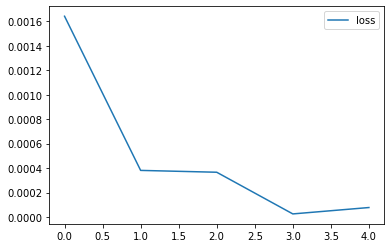

In [28]:
loss_df.plot()

In [29]:
first_batch = train[-50:]

In [30]:
first_batch.shape

(50, 1)

In [31]:
first_batch = first_batch.reshape(1, length, n_features)

In [32]:
first_batch.shape

(1, 50, 1)

In [33]:
model.predict(first_batch)

array([[0.8744025]], dtype=float32)

In [34]:
len(test)

101

In [35]:
test_predictions = []
first_batch = train[-length:]
current_batch = first_batch.reshape(1, length, n_features)

for i in range(len(test)):
    current_prediction = model.predict(current_batch)[0]
    test_predictions.append(current_prediction)
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis = 1)

In [36]:
len(test_predictions)

101

In [37]:
true_predictions = scaler.inverse_transform(test_predictions)

In [38]:
test_df.head()

,Sine
40.0,0.745113
40.1,0.674808
40.2,0.597760
40.3,0.514740
40.4,0.426577


In [39]:
test_df["RNN Predictions"] = true_predictions

/var/folders/4y/pcdt74h51_x2zz4w3hlpvzxh0000gn/T/ipykernel_14492/493039931.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["RNN Predictions"] = true_predictions


In [40]:
test_df.head()

,Sine,RNN Predictions
40.0,0.745113,0.748801
40.1,0.674808,0.679656
40.2,0.597760,0.604447
40.3,0.514740,0.524474
40.4,0.426577,0.437632


<AxesSubplot:>

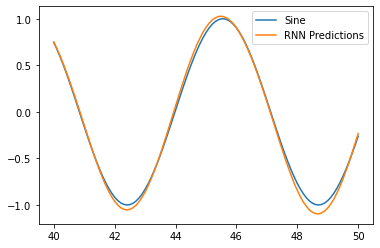

In [41]:
test_df.plot()

In [42]:
from tensorflow.keras.layers import LSTM

In [43]:
from tensorflow.keras.callbacks import EarlyStopping

In [48]:
early_stop = EarlyStopping(patience=2)

In [49]:
length = 40

generator = TimeseriesGenerator(train, train, length=length, batch_size=1)

test_generator = TimeseriesGenerator(test, test, length=length, batch_size=1)

In [50]:
model = Sequential()

model.add(LSTM(50, input_shape=(length, 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [51]:
model.fit(generator, epochs=30, validation_data=test_generator, callbacks=[early_stop])

Epoch 1/30
360/360 [==============================] - 14s 32ms/step - loss: 0.0273 - val_loss: 3.5422e-05
Epoch 2/30
360/360 [==============================] - 8s 23ms/step - loss: 1.2116e-04 - val_loss: 7.9758e-05
Epoch 3/30
360/360 [==============================] - 10s 27ms/step - loss: 4.5248e-04 - val_loss: 1.3200e-04


In [52]:
test_predictions = [] 
first_batch = train[-length:]
current_batch = first_batch.reshape(1, length, 1)

for i in range(len(test)):
    current_prediction = model.predict(current_batch)[0]
    test_predictions.append(current_prediction)
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis = 1)

In [53]:
true_predictions = scaler.inverse_transform(test_predictions)

In [54]:
test_df["LSTM Predictions"] = true_predictions

/var/folders/4y/pcdt74h51_x2zz4w3hlpvzxh0000gn/T/ipykernel_14492/3403782598.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["LSTM Predictions"] = true_predictions


In [55]:
test_df.head()

,Sine,RNN Predictions,LSTM Predictions
40.0,0.745113,0.748801,0.777592
40.1,0.674808,0.679656,0.711754
40.2,0.597760,0.604447,0.641440
40.3,0.514740,0.524474,0.566428
40.4,0.426577,0.437632,0.487036


<AxesSubplot:>

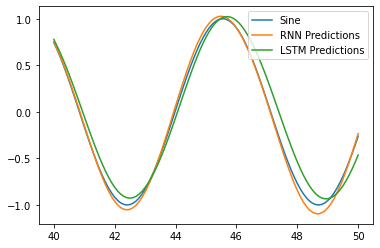

In [56]:
test_df.plot()